In [1]:
import sys
sys.path.insert(1, '/home/maria/Documents/EnsemblePursuit')
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, gaussian_filter1d

In [2]:
data_path='/home/maria/Documents/data_for_suite2p/TX39/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)
#Uncomment to compute U and V
ep=EnsemblePursuit(n_components=200,lam=0.01,n_kmeans=200)
model=ep.fit(S.T[:10000,:])
V=model.components_
U=model.weights
np.save('U.npy',U)

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)
obtained 200 PCs in 14.3127 seconds
initialized 200 clusters with k-means in 27.3413 seconds
ensemble 0, time 14.31, nr neurons 6340, EV 0.0086
ensemble 25, time 102.67, nr neurons 206, EV 0.0329
ensemble 50, time 170.51, nr neurons 90, EV 0.0420
ensemble 75, time 232.66, nr neurons 95, EV 0.0492
ensemble 100, time 290.18, nr neurons 100, EV 0.0551
ensemble 125, time 344.61, nr neurons 80, EV 0.0605
ensemble 150, time 396.57, nr neurons 50, EV 0.0652
ensemble 175, time 445.77, nr neurons 46, EV 0.0695
ensemble 199, time 491.43, nr neurons 41, EV 0.0734
average sparsity is 0.0100


In [8]:
#13
print(U.shape)
print(np.nonzero(U[:,13])[0])
print(S.shape)
print(S[np.nonzero(U[:,13])[0],:].shape)

(18795, 200)
[ 2879  2883  2890  2929  2955  2976  2980  3017  3033  3034  3082  3097
  3107  3117  3126  3137  3159  3167  3207  3210  3256  3266  3268  3286
  3291  3294  3316  3335  3360  3364  3368  3371  3372  3378  3426  3429
  3451  3456  3460  3482  3490  3491  3520  3561  3585  3612  3615  3618
  3641  3660  3663  3668  3677  3702  3724  3756  3760  3781  3809  3869
  3872  3878  3882  3939  3975  3988  3992  4004  4016  4030  4049  4054
  4083  4085  4086  4094  4095  4150  4159  4169  4182  4221  4247  4249
  4253  4285  4320  4356  4376  4381  4403  4418  4428  4435  4449  4463
  4474  4489  4501  4518  4521  4523  4566  4575  4578  4581  4588  4591
  4606  4617  4619  4641  4667  4671  4680  4682  4691  4733  4751  4755
  4776  4783  4786  4844  4855  4860  4922  4928  4946  4959  4973  4975
  4988  5004  5027  5039  5061  5067  5096  5107  5127  5158  5179  5200
  5214  5225  5228  5241  5261  5296  5312  5324  5359  5368  5370  5389
  5405  5434  5470  5474  5476  5486  

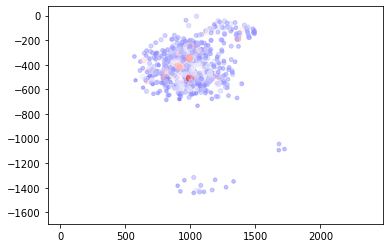

In [14]:
stat = np.load(('/home/maria/Documents/data_for_suite2p/TX39/'+'stat.npy'), allow_pickle=True) # these are the per-neuron stats returned by suite2p
# these are the neurons' 2D coordinates
ypos = np.array([stat[n]['med'][0] for n in range(len(stat))]) 
# (notice the python list comprehension [X(n) for n in range(N)])
xpos = np.array([stat[n]['med'][1] for n in range(len(stat))]) 
comp=U[:,13]
comp= comp/np.max(np.abs(comp))
lam = np.abs(comp) 
plt.scatter(xpos, -ypos, s = 50 * lam, c = comp, cmap='bwr', alpha = .5)

# Inject activity patterns without plasticity

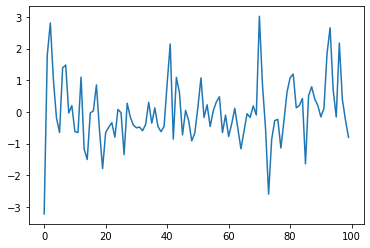

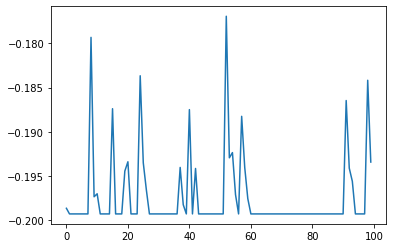

In [46]:
np.random.seed(7)
input_patterns=S[np.nonzero(U[:,13])[0],:]
input_patterns=zscore(input_patterns,axis=1)
v_lst=[]
w=np.random.normal(loc=0,size=(656,))
v_lst=[np.dot(w,input_patterns[:,0])]
for j in range(1,30560):
    v_lst.append(np.dot(w,input_patterns[:,j]))
    
plt.plot(zscore(v_lst[:100]))
plt.show()
plt.plot(input_patterns[1,:100])
v_lst=np.array(zscore(v_lst))

In [47]:
print(v_lst.shape)

(30560,)


In [52]:
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest

mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
ly, lx, nstim = mov.shape
#print(nstim)
NT = v_lst.shape[0]
NN=1
mov=mov[:,:,:NT]
print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ v_lst[itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, 1))
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a littleb

30560


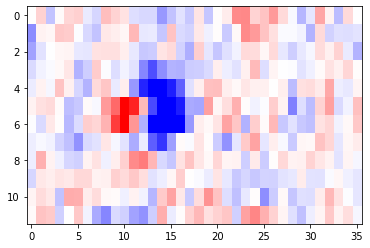

In [54]:
rf = B0[:,:,0]
rfmax = np.max(B0)
# rfmax = np.max(np.abs(rf))
plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax)

# Inject patterns with plasticity

(656, 30560)
(656, 999)


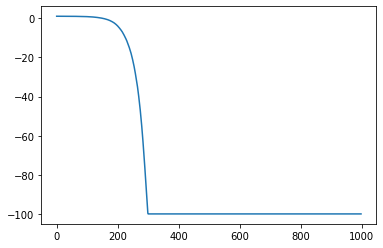

In [67]:
#Using Euler's method to calculate the weight increments
h=0.001
input_patterns=S[np.nonzero(U[:,13])[0],:]
input_patterns=zscore(input_patterns,axis=1)
print(input_patterns.shape)
v_lst=[]
w_lst=[]
w=np.random.normal(loc=0,size=(656,))
v_lst=[np.dot(w,input_patterns[:,1])]
for j in range(1,1000):
    v_lst.append(np.dot(w,input_patterns[:,j]))
    w=w+h*v_lst[-1]*input_patterns[:,j]
    w=np.clip(w,a_min=-100,a_max=100)
    w_lst.append(w)
w_arr=np.array(w_lst).T
print(w_arr.shape)
plt.plot(w_arr[0,:])

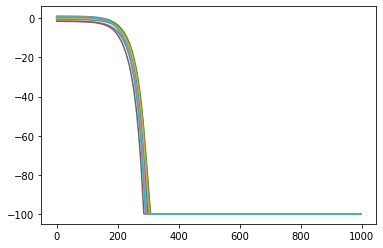

In [68]:
for j in range(0,10):
    plt.plot(w_arr[j,:])

In [69]:
v_lst=np.array(zscore(v_lst))
mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
ly, lx, nstim = mov.shape
#print(nstim)
NT = v_lst.shape[0]
NN=1
mov=mov[:,:,:NT]
print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ v_lst[itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, 1))
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a littleb

1000


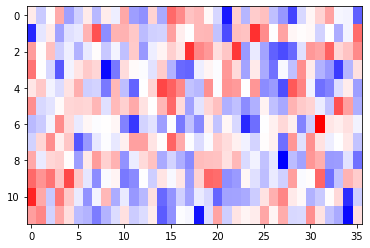

In [70]:
rf = B0[:,:,0]
rfmax = np.max(B0)
# rfmax = np.max(np.abs(rf))
plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax)